In [1]:
# Step 1: Create a directory to store the dataset
!mkdir -p /content/satellite_classification

# Step 2: Download the dataset using wget
!wget -O /content/satellite_classification/EuroSAT_RGB.zip "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1"

# Step 3: Unzip the dataset
!unzip -q /content/satellite_classification/EuroSAT_RGB.zip -d /content/satellite_classification/


--2025-08-03 16:24:25--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘/content/satellite_classification/EuroSAT_RGB.zip’

/content/satellite_ 100%[===================>]  90.27M  20.5MB/s    in 5.4s    

2025-08-03 16:24:32 (16.6 MB/s) - ‘/content/satellite_classification/EuroSAT_RGB.zip’ saved [94658721/94658721]



In [2]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define original dataset path (after unzipping EuroSAT_RGB)
ORIGINAL_DATASET = "/content/satellite_classification/EuroSAT_RGB"  # Update this path if needed
DATASET_PATH = "./EuroSAT_data"            # Target path with train/test folders

# Only run once to create train/test split
if not os.path.exists(DATASET_PATH):
    print("Creating train/test split...")

    classes = os.listdir(ORIGINAL_DATASET)
    for cls in classes:
        full_path = os.path.join(ORIGINAL_DATASET, cls)
        images = os.listdir(full_path)
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

        # Create class folders in train/test
        for split in ['train', 'test']:
            os.makedirs(os.path.join(DATASET_PATH, split, cls), exist_ok=True)

        for img in train_imgs:
            src = os.path.join(full_path, img)
            dst = os.path.join(DATASET_PATH, 'train', cls, img)
            shutil.copy(src, dst)

        for img in test_imgs:
            src = os.path.join(full_path, img)
            dst = os.path.join(DATASET_PATH, 'test', cls, img)
            shutil.copy(src, dst)

    print(" Done splitting dataset!")


Creating train/test split...
 Done splitting dataset!


In [4]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

DATASET_PATH = '/content/EuroSAT_data'

BATCH_SIZE = 64 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0005

In [5]:
# Create datasets and data loaders
# Transformations

from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes

print('Dataloaders OK')
test_loader

Dataloaders OK


Image label: 6


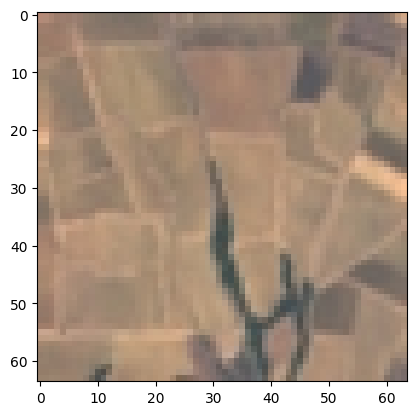

In [6]:
#Print the corresponding label for the image

random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)

# Convolutional Neural Network Architecture

In [8]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 4 feature maps is
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(64-3+2(1)/1)+1] = 64 (padding type is same)
        self.batchnorm1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        #After max pooling, the output of each feature map is now 64/2 =32
        self.cnn2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        #Output size of each of the 32 feature maps
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        #After max pooling, the output of each feature map is 32/2 = 16
        #Flatten the feature maps. You have 8 feature maps, each of them is of size 16x16 --> 8*16*16 = 2048
        self.fc1 = nn.Linear(in_features=8*16*16, out_features=32)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=10)

    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before!
        #It will take the shape (batch_size, 2048)
        out = out.view(x.size(0), -1)

        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        #out = self.droput(out)
        out = self.fc2(out)
        return out

# Create models

In [9]:
# Create network
model = CNN()
if USE_CUDA:
    model = model.cuda()

print('Network OK')

Network OK


In [10]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training with CNN



Running epoch 1 of 25...


Epoch 1 validation results: Loss=1.1395633522201987 | Accuracy=57.35185241699219



Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.9038252250236624 | Accuracy=66.24073791503906



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.8108847959953196 | Accuracy=71.25926208496094



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.747717938878957 | Accuracy=73.68518829345703



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.6939427794779048 | Accuracy=75.0



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 6 of 25...


Epoch 6 validation results: Loss=0.6544308386304799 | Accuracy=77.20370483398438



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 7 of 25...


Epoch 7 validation results: Loss=0.6717773126986097 | Accuracy=75.75926208496094



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 8 of 25...


Epoch 8 validation results: Loss=0.5793956728542552 | Accuracy=79.64814758300781



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 9 of 25...


Epoch 9 validation results: Loss=0.5754706693046233 | Accuracy=79.94444274902344



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 10 of 25...


Epoch 10 validation results: Loss=0.5714511550962925 | Accuracy=80.24073791503906



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 11 of 25...


Epoch 11 validation results: Loss=0.5722311027348042 | Accuracy=80.29629516601562



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 12 of 25...


Epoch 12 validation results: Loss=0.5688494203721776 | Accuracy=80.25926208496094



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 13 of 25...


Epoch 13 validation results: Loss=0.5719807271133451 | Accuracy=80.0740737915039



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 14 of 25...


Epoch 14 validation results: Loss=0.5684024168726276 | Accuracy=80.18518829345703



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 15 of 25...


Epoch 15 validation results: Loss=0.5638790928265628 | Accuracy=80.14814758300781



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 16 of 25...


Epoch 16 validation results: Loss=0.5617001250824507 | Accuracy=80.44444274902344



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 17 of 25...


Epoch 17 validation results: Loss=0.5623453790650649 | Accuracy=80.5740737915039



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 18 of 25...


Epoch 18 validation results: Loss=0.5632717017303495 | Accuracy=80.4259262084961



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 19 of 25...


Epoch 19 validation results: Loss=0.5648640768931192 | Accuracy=80.33333587646484



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 20 of 25...


Epoch 20 validation results: Loss=0.5618923081632923 | Accuracy=80.27777862548828



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)




Running epoch 21 of 25...



/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)



Epoch 21 validation results: Loss=0.5637649615021313 | Accuracy=80.51851654052734



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 22 of 25...


Epoch 22 validation results: Loss=0.5603742110378602 | Accuracy=80.59259033203125



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 23 of 25...


Epoch 23 validation results: Loss=0.5614408754250583 | Accuracy=80.40740966796875



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 24 of 25...


Epoch 24 validation results: Loss=0.5632005193654228 | Accuracy=80.31481170654297



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)




Running epoch 25 of 25...


Epoch 25 validation results: Loss=0.5626811387346071 | Accuracy=80.48148345947266



/tmp/ipython-input-1172018319.py:77: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(figsize=(12, 8), num=1)
/tmp/ipython-input-1172018319.py:88: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figsize=(12, 8), num=2)


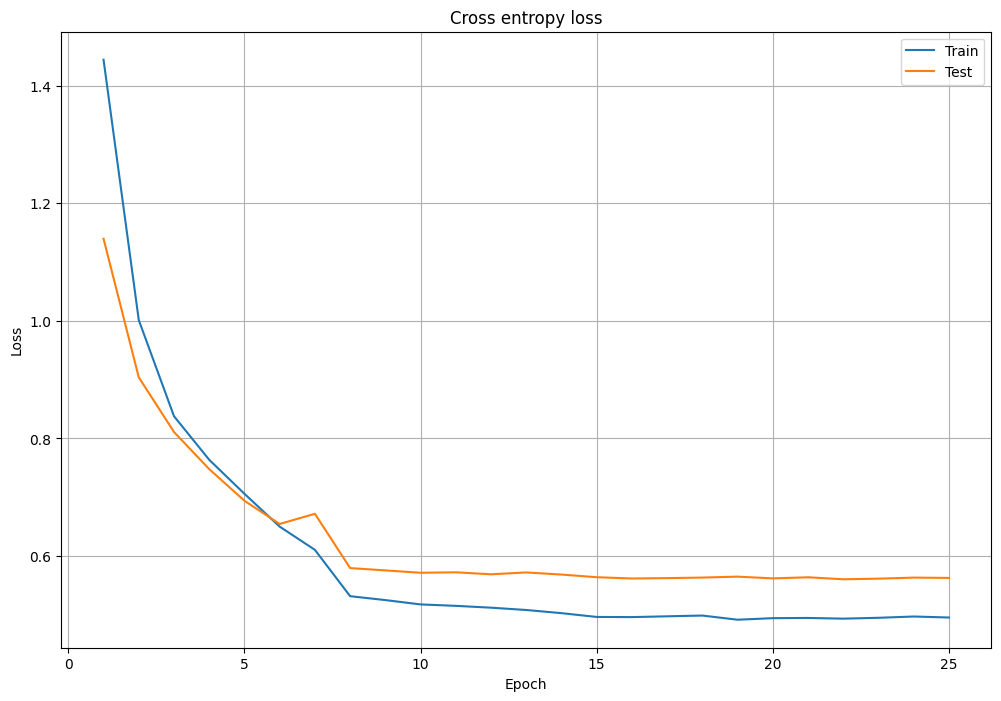

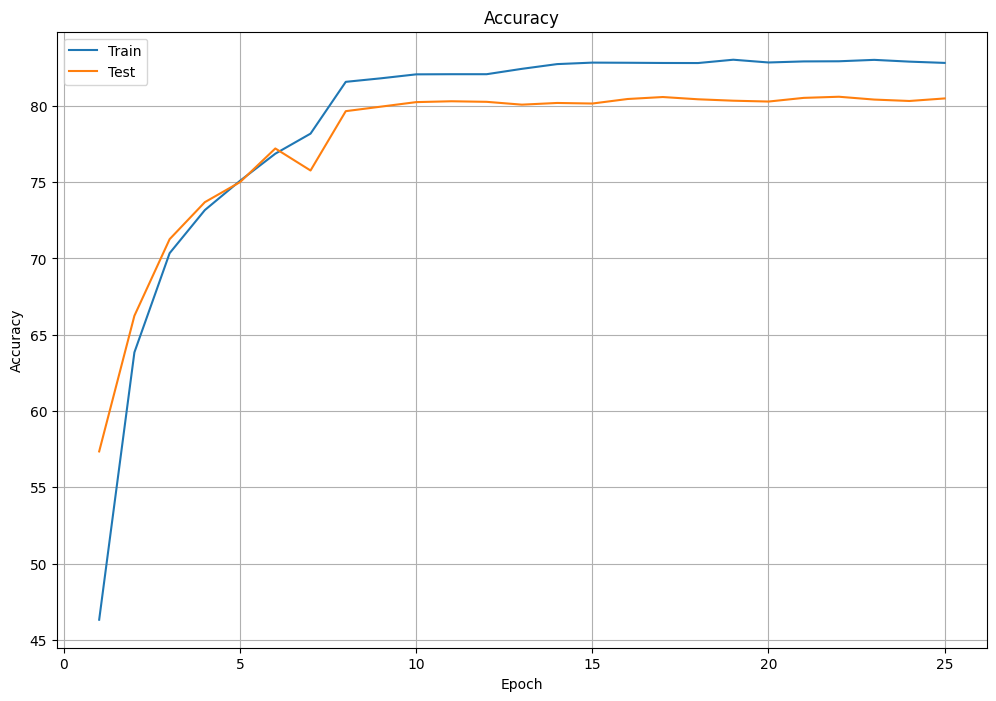

In [11]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------

    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()  # Put the network into training mode

    for i, (inputs, labels) in enumerate(train_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation
        optimizer.step()  # Update the weights

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    scheduler.step()

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))

    #-------------------------Test--------------------------

    correct = 0
    iterations = 0
    testing_loss = 0.0

    model.eval()  # Put the network into evaluation mode

    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))

    print(f'\nEpoch {epoch} validation results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')

    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-cnn.pdf')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-cnn.pdf')

# Results

In [12]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.4953315839083237
Final test loss: 0.5626811387346071
Final train accuracy: 82.81018829345703
Final test accuracy: 80.48148345947266


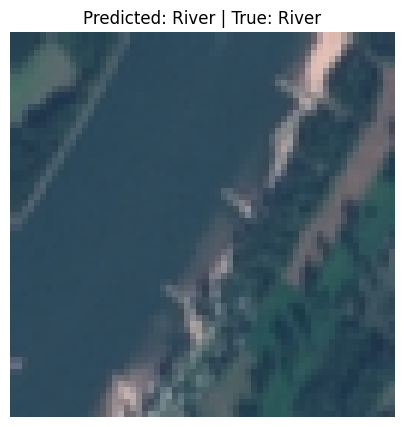

In [13]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# Set model to evaluation mode
model.eval()

# Get one random sample from the test dataset
sample_idx = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[sample_idx]

# Add a batch dimension
input_image = image.unsqueeze(0)

if USE_CUDA:
    input_image = input_image.cuda()

# Get prediction
with torch.no_grad():
    output = model(input_image)
    _, predicted_class = torch.max(output, 1)

# Convert tensor image to numpy for plotting
# Denormalize before displaying (reverse of Normalize transform)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
img = image.permute(1, 2, 0) * std + mean  # De-normalize
img = img.clamp(0, 1).cpu().numpy()       # Clamp to valid range

# Plot
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {class_names[predicted_class.item()]} | True: {class_names[true_label]}')
plt.show()
